# Convolutional Autoencoder for Image Denoising
# 이미지 노이즈 제거를 위한 컨볼루션 오토인코더

 이미지 노이즈 제거를 위한 딥 컨볼루션 자동 인코더를 구현하고 MNIST 데이터 세트의 노이즈가 있는 숫자 이미지를 깨끗한 숫자 이미지로 매핑하는 방법을 알아보자.

## 0. 필요한 모듈 불러오기

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

----

## 1. 필요한 함수 정의

노이즈가 있는 이미지를 깨끗한 이미지로 매핑하기 위해 필요한 함수를 생성하자. 각 함수의 기능은 아래와 같다.
- `preprocess` : 이미지 데이터의 값을  0~1 사이의 값으로 정규화 후 알맞은 포멧형식으로 바꿈
- `noise` : 이미지에 랜덤한 노이즈를 추가
- `display` : 10개의 무작위의 데이터를 시각화

In [2]:
def preprocess(array):
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

----

## 2. 데이터 준비

MNIST 데이터를 불러온다. 이때, 데이터셋의 encode 와 decode 과정만 보기 위함이므로, label 은 필요하지 않다.

In [3]:
# MNIST 데이터 불러오기, label 값을 필요로 하지 않음
(train_data, _), (test_data, _) = mnist.load_data()

print(f'훈련 데이터 : {len(train_data)}, 테스트 데이터 : {len(test_data)}')

훈련 데이터 : 60000, 테스트 데이터 : 10000


위의 함수를 이용하여 데이터를 전처리하고, noise가 추가된 새로운 훈련, 데이터셋을 만는다.

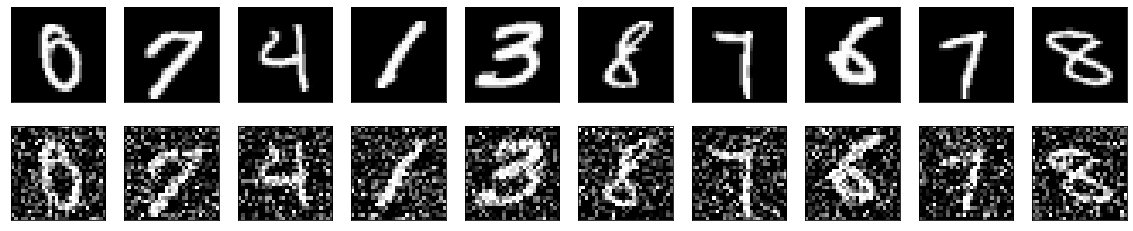

In [4]:
# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

----
## 3. Autoencoder 설계
Functional API를 사용하여 convolutional autoencoder를 만들자.

In [5]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248  

## 4. Autoencoder 훈련 및 결과 확인

 train_data 입력 데이터를 사용하여 자동 인코더를 훈련시킨다.

In [6]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 20s 29ms/step - loss: 0.2409 - val_loss: 0.0732
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0726 - val_loss: 0.0696
Epoch 3/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0697 - val_loss: 0.0681
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0684 - val_loss: 0.0672
Epoch 5/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0675 - val_loss: 0.0666
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0668 - val_loss: 0.0660
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0663 - val_loss: 0.0656
Epoch 8/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0660 - val_loss: 0.0652
Epoch 9/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0656 - val_loss: 0.0650
Epoch 10/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0652 - val_l

테스트 데이터 세트에서 예측하고 자동 인코더의 예측과 함께 원본 이미지를 표시해 보겠다.


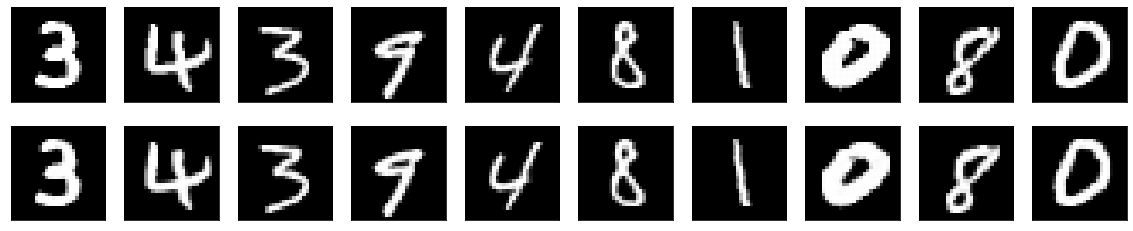

In [7]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

비록 완전히 같지는 않지만 예측이 원본 이미지와 얼마나 가까운지 확인 할 수 있다.

이제 오토인코더가 작동한다는 것을 알았으므로 잡음이 있는 데이터를 입력으로 사용하고 깨끗한 데이터를 대상으로 사용하여 다시 훈련시킨다.

이때, 조기 종료'를 뜻하는 EarlyStopping 은 특정 조건이 충족되면 훈련을 멈추는 역할을 한다.

위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정했다.

In [8]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    callbacks=[es],
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 6s 13ms/step - loss: 0.1004 - val_loss: 0.0931
Epoch 2/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0928 - val_loss: 0.0911
Epoch 3/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0912 - val_loss: 0.0899
Epoch 4/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0902 - val_loss: 0.0890
Epoch 5/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0894 - val_loss: 0.0884
Epoch 6/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0889 - val_loss: 0.0880
Epoch 7/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0884 - val_loss: 0.0875
Epoch 8/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0881 - val_loss: 0.0872
Epoch 9/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0877 - val_loss: 0.0869
Epoch 10/100
469/469 [==============================] - 6s 13ms/step - loss: 0.087

이제 노이즈가 있는 데이터를 예측하고 자동 인코더의 결과를 표시한다.

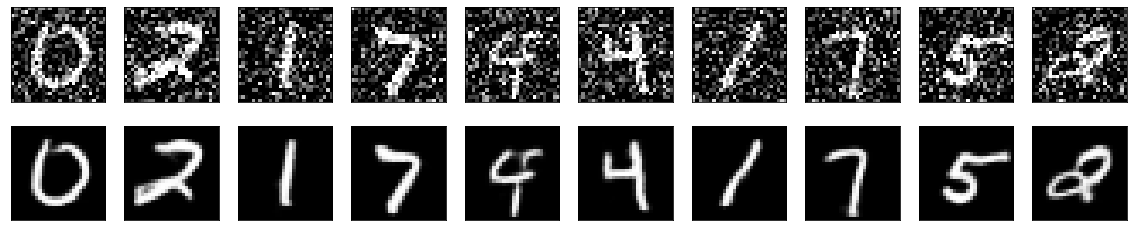

In [9]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

자동 인코더가 입력 이미지에서 노이즈를 제거하는 작업을 잘 수행한 것을 알 수 있다.

----
## Autoencoder 가 사용되는 예시


![image](https://user-images.githubusercontent.com/84179578/129895388-b7bd54d6-8c4a-4cda-afe5-44e5d2a094aa.png)

입력 데이터를 압축 시킨 후 다시 확장 시키는 네트워크

**unsupervised learning** 에서 자주 쓰인다.

unsupervised learning이란
- 정답이 없는 학습 방법
  - 생성 모델
  ![image](https://user-images.githubusercontent.com/84179578/129895413-fe599943-9f7e-48c3-b10b-46a0553434ca.png)

  
  - 슬로우 모션 생성
  > [참고 Github](https://github.com/avinashpaliwal/Super-SloMo)
  
  - 이미지 빈 곳 생성
  
  ![image](https://user-images.githubusercontent.com/84179578/129895434-f27be472-9078-46dc-90b6-f3da1a2e1717.png)
  
  
  
  

> 참고 링크 : [데이터를 압축하고 생성하는 AutoEncoder](https://ssung-22.tistory.com/55) , [AutoEncoder란 무엇인가](https://deepinsight.tistory.com/126)